# Evaluating Models

See model_training for tuning and training models. This is focused on loading models and evaluating their accuracy.

TLDR:
    - XGBoost performs the best with an 11% improvement over the mean whereas second best is only a 5% improvement.
    - All models struggle to predict well for individuals with high hourly rates (> 60 or so)
 
Next Steps:
    - Run truth vs prediction graph by subgroups to determine if there are areas where the model could be improved. Specifically, I'm interested in knowing if there are certain skill categories or states where it performs very well or very poorly. For this I may be best off creating a dataframe with {y_test | y_pred | X_test} and calculating means for subgroups or something. 
    - I'm also wondering if I can collapse my columns down more. Reduce state indicators into large groups. Idea here is that the hourly rate is relatively homogenous across some states. Have to think about this more. Maybe do EDA (visualization notebook).
    - Try to work in the supply / demand aspect from client data.
    

# Library and Data Imports

In [9]:
# Data Analysis and Modeling
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# AdaBoost Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# LASSO
from sklearn.linear_model import LassoCV, Lasso

# XGBoost
import xgboost as xgb

# Cross-Validation and Accuracy Measures
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

# Model Serializing (export to web-app)
import pickle

# Packages for PostgreSQL Import
import psycopg2
import os

## Importing Data from SQL

In [10]:
# Names for accessing SQL database
dbname = "freelance_db"
username = os.environ['USER']
pswd = os.environ['SQLPSWD']

# Connect to SQL Database
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# Importing Data
sql_query = """SELECT * FROM analysis_dummies_table;"""
analysis_dt = pd.read_sql_query(sql_query, con)

sql_query = """SELECT * FROM embeddings_table;"""
embeddings = pd.read_sql_query(sql_query, con)

# Doing some cleaning. Removing columns that have a continuous analog in the model.
analysis_dt = analysis_dt.drop(['index'], axis=1)
analysis_dt = analysis_dt.drop(['first_skill'], axis = 1)

# Removing index col from embeddings
embeddings = embeddings.drop(['index'], axis = 1)
embeddings['profile_url'] = "https://www.guru.com" + embeddings['profile_url']

# Merging on profile_url
analysis_dt = analysis_dt.merge(embeddings, how = "left", 
                                left_on = "profile_url", right_on= "profile_url")
analysis_dt = analysis_dt.drop(['profile_url'], axis = 1)
analysis_dt = analysis_dt.fillna(0)

# Cleaning avg_word_length and bio_word count
analysis_dt.loc[analysis_dt['bio_length'] == 0, ['bio_word_count','avg_word_length']] = 0

# Removing Crazy Outliers
analysis_dt.drop(analysis_dt[analysis_dt['hourly_rate'] > 100].index, inplace = True)
analysis_dt.shape

(964, 114)

## Getting Training and Test Splits

Note the random state is the same as in the model training notebook. This is to ensure I get the same data.

In [11]:
# Converting data to numpy arrays and saving column names
y = np.array(analysis_dt['hourly_rate'])

analysis_dt = analysis_dt.drop(['hourly_rate'], axis = 1)
feature_list = list(analysis_dt.columns)

X = np.array(analysis_dt)

In [12]:
# Creating train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Defining Functions for Evaluation

In [27]:
def baseline_performance(outcome_data, test_data):
    # Assumes training the mean
    
    # Getting Baseline
    baseline_preds = np.mean(outcome_data)

    # Baseline Errors
    baseline_errors = abs(baseline_preds - test_data)

    # Baseline:
    print('Baseline Performance of Naive Mean Estimator:\nMean Absolute Error:', round(np.mean(baseline_errors), 2))
    
    return np.mean(baseline_errors)
    
def model_performance(predictions, outcome_data, baseline, model_str_name):
    # Calculate absolute error (comparison with baseline)
    errors = abs(predictions - outcome_data)
    
    print(model_str_name + ' Performance:')
    
    # Print out the mean absolute error (mae)
    print('\tMean absolute error: %.2f'
          % mean_absolute_error(outcome_data, predictions))

    # The mean squared error
    print('\tMean squared error: %.2f'
          % mean_squared_error(outcome_data, predictions))

    # The coefficient of determination (R2)
    print('\tCoefficient of determination: %.2f'
          % r2_score(outcome_data, predictions))

    # Does much better than the mean with regard to mean absolute error
    print("\tA ", round((np.mean(errors)-baseline)/baseline,3)*-100,
          "percent change over the mean")
    
    # What is the average dollar change in user hourly rate with this model?
    print("\tAverage Change in Hourly Rate vs Naive Model: $", np.mean(predictions - baseline))

def plot_preds_truth(x, y):
    # Calculate Error
    error = abs(x-y)
    
    # Plotting True Hourly Rates vs Predicted Hourly Rates
    sns.scatterplot(x = x, y = y, hue = error)
    sns.lineplot(x = range(0,100), y = range(0,100), palette=['red'])
    plt.ylim(0, None)
    plt.xlim(0, None)
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.show()
    
# Aggregate Function: Model_performance
def model_evaluation(model, model_name_string):

    if model_name_string == 'XGBoost':
        
        # Converting data to useable format 
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # Evaluating Model
        model_performance(model.predict(dtest), y_test, pred_baseline, 'model_name_string')

        # Plotting True Hourly Rates vs Predicted Hourly Rates
        plot_preds_truth(x = y_test, y = model.predict(dtest))
        
    else:
        
        # Evaluating Model
        model_performance(model.predict(X_test), y_test, pred_baseline, 'model_name')

        # Plotting True Hourly Rates vs Predicted Hourly Rates
        plot_preds_truth(x = y_test, y = model.predict(X_test))


# Loading Models

In [21]:
# XGBoost
model_xgboost = xgb.Booster({'nthread': 4})  # init model
model_xgboost.load_model(os.environ['PWD'] + '/scripts/model_xgb.model')  # load data

# Lasso
filename = os.environ['PWD'] + '/scripts/model_lasso.sav'
model_lasso = pickle.load(open(filename, 'rb'))

# Random Forest Regression
filename = os.environ['PWD'] + '/scripts/model_rfr.sav'
model_rfr = pickle.load(open(filename, 'rb'))

# AdaBoost
filename = os.environ['PWD'] + '/scripts/model_ada.sav'
model_ada = pickle.load(open(filename, 'rb'))

# Evaluating Models

Looking at the Mean Absolute Error (MAE), Coefficient of Determination, and Mean Squared Error. Also, I look at the dollar difference between the naive model (mean predict) and my model. Lastly, I print a graphic that visualizes where the model does and doesn't perform well. Later I'll build upon this graphic to subgroups.

## Baseline Performance
This is the performance of an estimator trained on the mean of the training data. Purely looking at the MAE, the XGBoost models performs above and beyond all the other models. 

Baseline Performance of Naive Mean Estimator:
Mean Absolute Error: 17.69


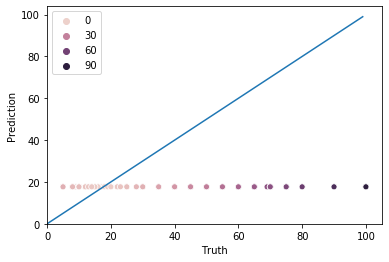

In [22]:
pred_baseline = baseline_performance(y_train, y_test)
plot_preds_truth(x = y_test, y = pred_baseline)

## Model Performance

model_name_string Performance:
	Mean absolute error: 15.68
	Mean squared error: 446.01
	Coefficient of determination: 0.03
	A  11.4 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 5.518999


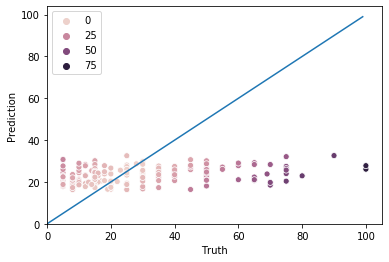

In [28]:
# XGBoost
model_evaluation(model_xgboost, 'XGBoost')

model_name Performance:
	Mean absolute error: 16.94
	Mean squared error: 442.01
	Coefficient of determination: 0.04
	A  4.2 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 11.642272749062325


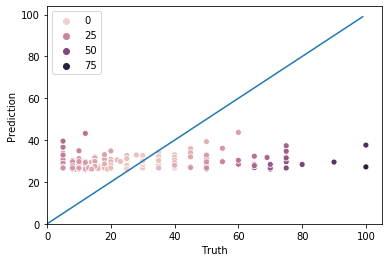

In [29]:
# Lasso
model_evaluation(model_lasso, 'LASSO')

model_name Performance:
	Mean absolute error: 16.78
	Mean squared error: 432.31
	Coefficient of determination: 0.06
	A  5.1 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 11.77153431689999


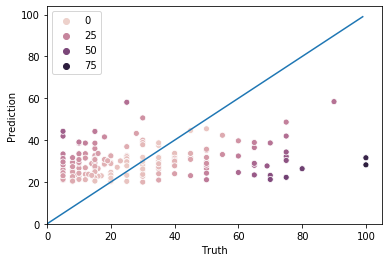

In [30]:
# Random Forest
model_evaluation(model_rfr, 'Random Forest Regression')

model_name Performance:
	Mean absolute error: 17.82
	Mean squared error: 457.09
	Coefficient of determination: 0.01
	A  -0.7000000000000001 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 14.341972998078566


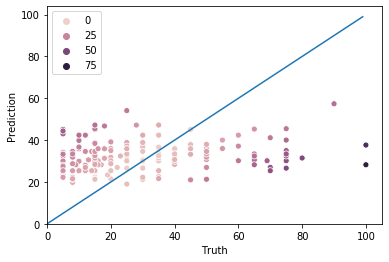

In [31]:
# AdaBoost
model_evaluation(model_ada, 'AdaBoosted Regression Trees')